### RMSE de validación cruzada

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

np.random.seed(1234)

def make_poly_data(sample_size=11):
    x = np.arange(0, sample_size)
    y = 3 + x + 4 * x**2 + np.random.normal(loc=0, scale=20, size=sample_size)
    return pd.DataFrame({'x': x, 'y': y})

In [17]:
poly_data=make_poly_data()

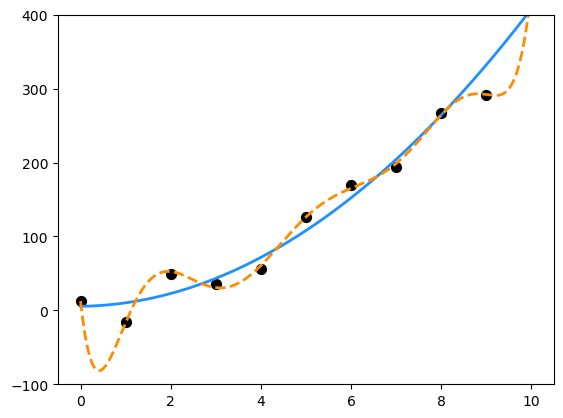

In [23]:


# Plotting
plt.scatter(poly_data.x, poly_data.y, c='black', s=50)
xplot = np.linspace(0, 10, 1000)
X_quad_plot = np.column_stack((xplot, xplot**2))
X_quad_plot = sm.add_constant(X_quad_plot)
plt.plot(xplot, fit_quad.predict(X_quad_plot), color='dodgerblue', linewidth=2)

X_big_plot = np.column_stack([xplot**i for i in range(1, 9)])
X_big_plot = sm.add_constant(X_big_plot)
plt.plot(xplot, fit_big.predict(X_big_plot), color='darkorange', linestyle='dashed', linewidth=2)
plt.ylim(-100, 400)
plt.show()




## Mira el error de los residuales que es 

In [34]:
rmse_quad=np.sqrt(np.mean(fit_quad.resid**2))
print(rmse_quad)
rmse_big=np.sqrt(np.mean(fit_big.resid**2))
print(rmse_big)


def calc_loocv_rmse(model):
    X=model.model.exog
    hat_matriz=X@np.linalg.inv(X.T@X)@X.T
    loocv_resid=model.resid/(1-np.diag(hat_matriz))
    loocv_rmse=np.sqrt(np.mean(loocv_resid**2))
    return loocv_rmse

###Validacion cruzada


print(calc_loocv_rmse(fit_quad))
print(calc_loocv_rmse(fit_big))






21.256664920062992
3.238542538524393
32.96049393106973
421.69183866305417


Ahora vemos que el modelo cuadrático tiene un LOOCV mucho menor RMSE, por lo que prefiríamos este modelo cuadrático. Esto se debe a que el modelo grande tiene severely over-fit los datos. Dejando un solo punto de datos fuera y ajustando el modelo grande, el ajuste resultante es muy diferente al ajuste utilixando todos los datos. Por ejemplo,dejemos fuera el tercer punto de datos y ajustemos ambos modlos 

## Ahora queremos ver Cómo elegimos que modelos?

In [36]:
import faraway.utils
import faraway.datasets.seatpos
seatpos = faraway.datasets.seatpos.load()
seatpos.head(20)


,Age,Weight,HtShoes,Ht,Seated,Arm,Thigh,Leg,hipcenter
0,46,180,187.2,184.9,95.2,36.1,45.3,41.3,-206.300
1,31,175,167.5,165.5,83.8,32.9,36.5,35.9,-178.210
2,23,100,153.6,152.2,82.9,26.0,36.6,31.0,-71.673
3,19,185,190.3,187.4,97.3,37.4,44.1,41.0,-257.720
4,23,159,178.0,174.1,93.9,29.5,40.1,36.9,-173.230
5,47,170,178.7,177.0,92.4,36.0,43.2,37.4,-185.150
6,30,137,165.7,164.6,87.7,32.5,35.6,36.2,-164.750
7,28,192,185.3,182.7,96.9,35.8,39.9,43.1,-270.920
8,23,150,167.6,165.0,91.4,29.4,35.5,33.4,-151.780
9,29,120,161.2,158.7,85.2,26.6,31.0,32.8,-113.880


In [49]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

X=sm.add_constant(seatpos.drop(columns='hipcenter'))
hipcenter_mod=sm.OLS(seatpos['hipcenter'],X).fit()
print(hipcenter_mod.summary())
print(hipcenter_mod.params)

                            OLS Regression Results                            
Dep. Variable:              hipcenter   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     7.940
Date:                Wed, 08 Nov 2023   Prob (F-statistic):           1.31e-05
Time:                        12:17:11   Log-Likelihood:                -186.73
No. Observations:                  38   AIC:                             391.5
Df Residuals:                      29   BIC:                             406.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        436.4321    166.572      2.620      0.0

## Búsqueda hacia atrás

In [76]:
##No hay funcion incoporada en ninguno de los paquetes para hacer este procedimineto, a continuación se presenta una funcion que realiza la búsqueda hacia atrás usando como cirterio de calidad el CIC

import numpy as np
import statsmodels.api as sm
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.base import BaseEstimator, RegressorMixin
from my_functions import select_features_using_criterion


X=seatpos.drop(columns='hipcenter',axis=1)
y=seatpos['hipcenter']

sfs_result_aic=select_features_using_criterion(X,y,criterion='aic',forward=True,floating=False)
selected_features_aic = X.columns[list(sfs_result_aic.k_feature_idx_)]
print(f"Selected Features based on AIC: {selected_features_aic}")


# Adjust a full model using only the selected features
X_selected = X[selected_features_aic]
hipcenter_mod_step_aic = sm.OLS(y, sm.add_constant(X_selected)).fit()

# Print the model summary
print(hipcenter_mod_step_aic.summary())






Selected Features based on AIC: Index(['Age', 'Ht', 'Leg'], dtype='object')
                            OLS Regression Results                            
Dep. Variable:              hipcenter   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                     24.24
Date:                Wed, 08 Nov 2023   Prob (F-statistic):           1.43e-08
Time:                        13:12:42   Log-Likelihood:                -187.04
No. Observations:                  38   AIC:                             382.1
Df Residuals:                      34   BIC:                             388.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

## Seleccionar modelos de regresión Con AIC o BIC

## Sesgo y Varianza


A menudo se utilizan los términos de "sesgo" y "varianza" o "compensación entre sesgo y varianza" para describir el rendimiento de un modelo; por ejemplo, es posible que encuentre charlas, libros o artículos en los que se diga que un modelo tienen una varianza o sesgo elevados. Qué siginica esto? En general, podríamos decir que una "alta varianza" es proporcional a un ajuste excesivo (overtfiting) y un "alto sesgo" es proporcional a un ajuste insuficiente (underfiting).


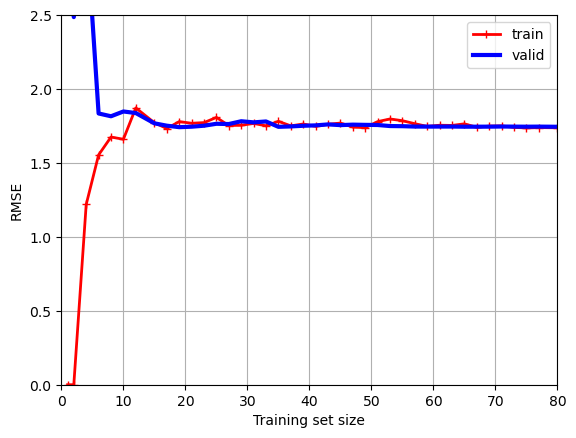

In [82]:
from sklearn.model_selection import learning_curve

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)




train_sizes, train_scores, valid_scores = learning_curve(
    LinearRegression(), X, y, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)


plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.legend(loc="upper right")
plt.axis([0, 80, 0, 2.5])
plt.show()

In [83]:
from sklearn.pipeline import make_pipeline

polynomial_regression = make_pipeline(
    PolynomialFeatures(degree=10, include_bias=False),
    LinearRegression())

train_sizes, train_scores, valid_scores = learning_curve(
    polynomial_regression, X, y, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")

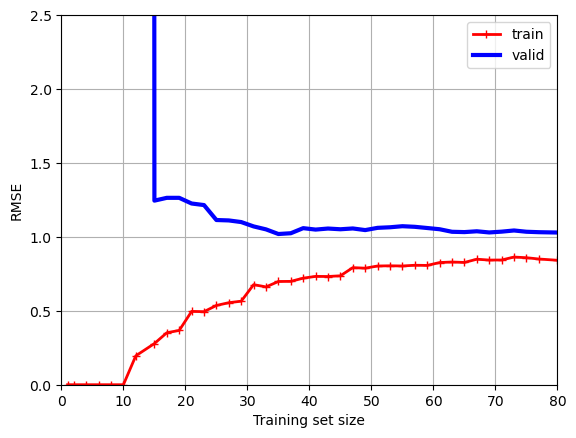

In [84]:


train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
plt.legend(loc="upper right")
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.axis([0, 80, 0, 2.5])
plt.show()



## Preguntas RLM3

In [85]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf




## Exploración Inicial

In [179]:
df_wines=pd.read_csv("winequality.csv",sep=";")
df_wines.head()
# Assuming df_wines is your DataFrame
# Assuming df_wines is your DataFrame
# Assuming df_wines is your DataFrame
# Assuming df_wines is your DataFrame
#Siempre reemplazar el vacio por _
df_wines.columns = [column.replace(' ', '_') for column in df_wines.columns]



In [180]:
df_wines.dtypes

fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
wine                     object
dtype: object

## Matriz de correlación

C:\Users\David\AppData\Local\Temp\ipykernel_27812\2192370401.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_wines.corr()


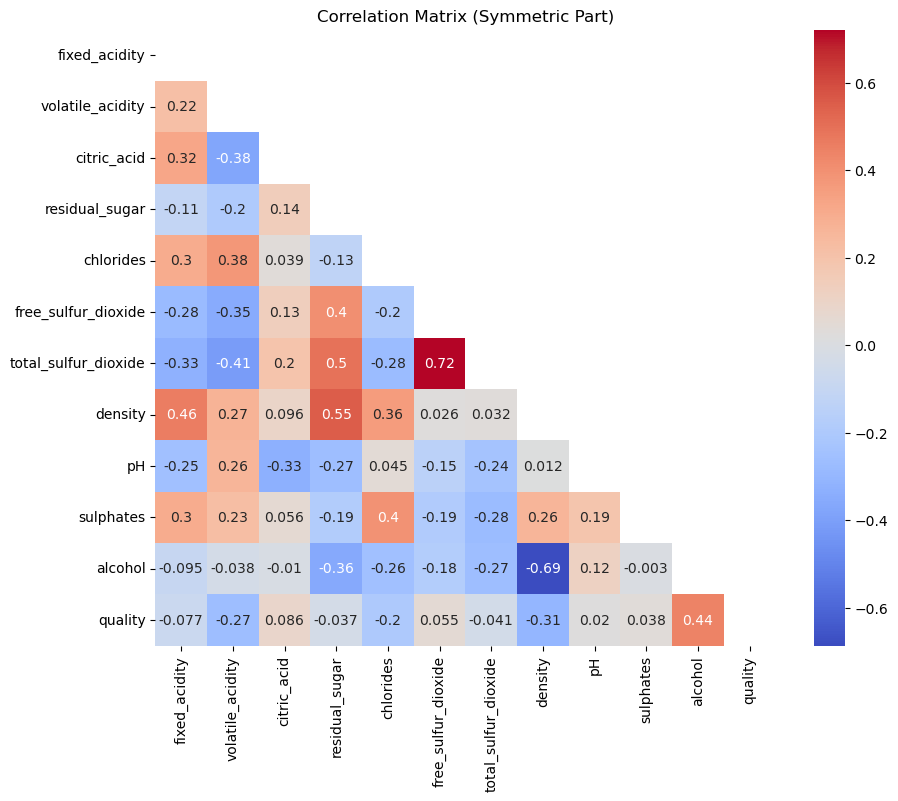

In [181]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_wines is your DataFrame
# Calculate the correlation matrix
corr_matrix = df_wines.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a heatmap of the symmetric part of the correlation matrix
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=True)

# Set the title
plt.title('Correlation Matrix (Symmetric Part)')

# Show the plot
plt.show()


C:\Users\David\AppData\Local\Temp\ipykernel_27812\43360392.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_white_wines.corr()


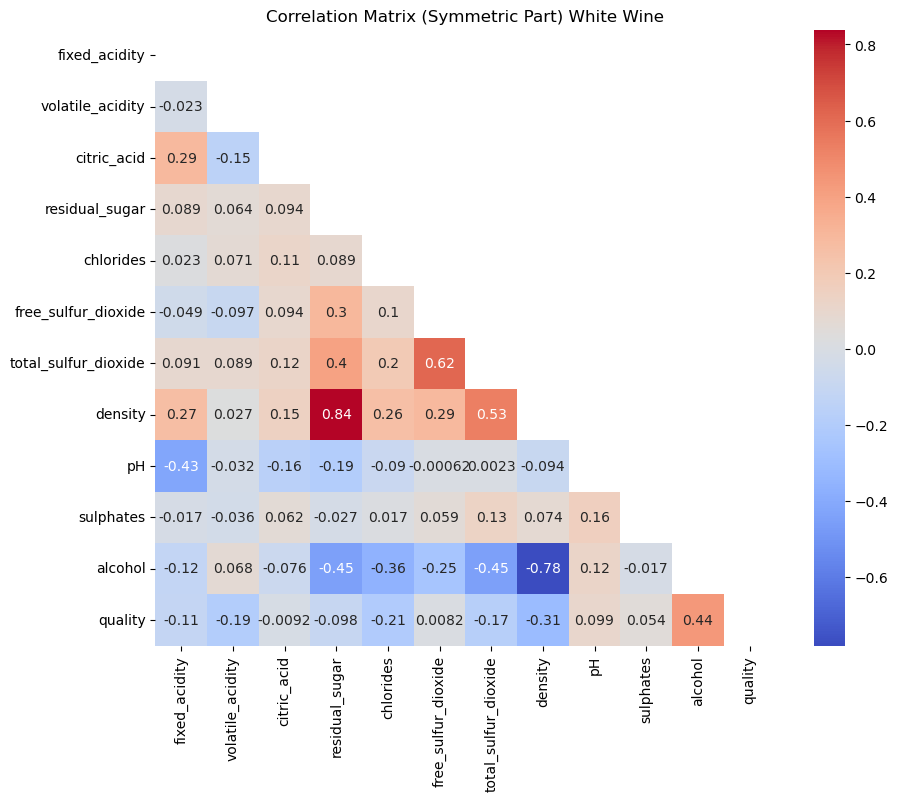

In [189]:
df_white_wines=df_wines[df_wines['wine']=='w']
df_red_wines=df_wines[df_wines['wine']=='r']

#plot correlation matrix for this two dataframes

corr_matrix = df_white_wines.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a heatmap of the symmetric part of the correlation matrix
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=True)

# Set the title
plt.title('Correlation Matrix (Symmetric Part) White Wine')

# Show the plot
plt.show()

C:\Users\David\AppData\Local\Temp\ipykernel_27812\554949860.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_red_wines.corr()


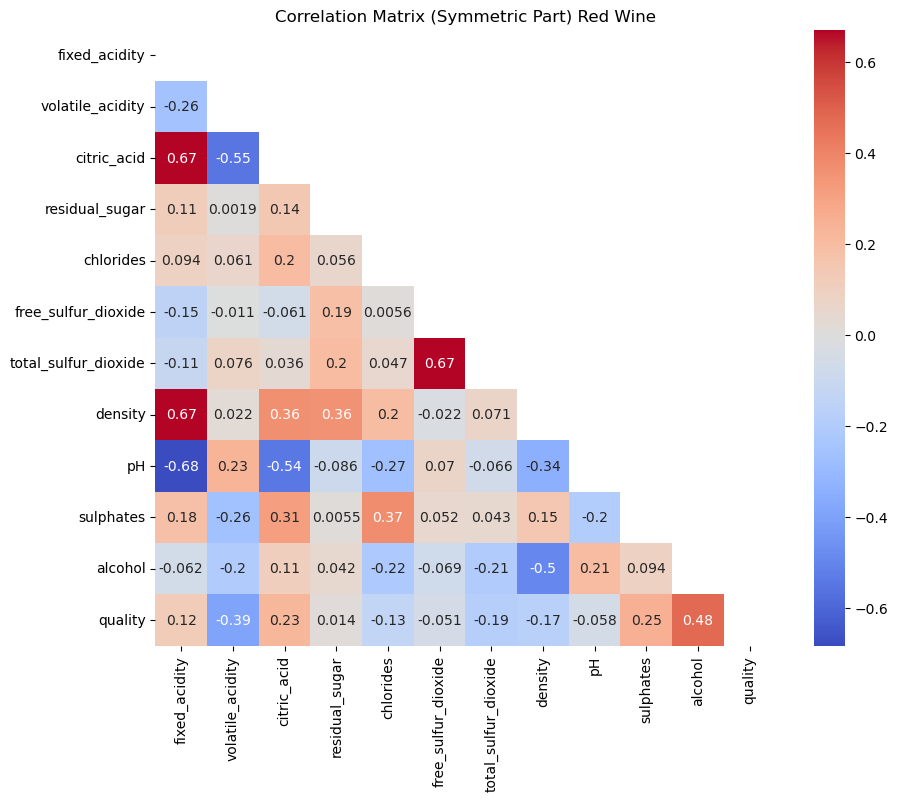

In [190]:
df_white_wines=df_wines[df_wines['wine']=='w']
df_red_wines=df_wines[df_wines['wine']=='r']

#plot correlation matrix for this two dataframes

corr_matrix = df_red_wines.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a heatmap of the symmetric part of the correlation matrix
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=True)

# Set the title
plt.title('Correlation Matrix (Symmetric Part) Red Wine')

# Show the plot
plt.show()

In [194]:
df_white_wines=df_wines[df_wines['wine']=='w']
df_red_wines=df_wines[df_wines['wine']=='r']



# ### Vamos a crear un modelo de regresión simple que explique la variable denstiy
modelo_density_basic = smf.ols('density ~ fixed_acidity', data=df_red_wines).fit()
print(modelo_density_basic.summary())



                            OLS Regression Results                            
Dep. Variable:                density   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     1287.
Date:                Wed, 08 Nov 2023   Prob (F-statistic):          3.07e-207
Time:                        17:43:20   Log-Likelihood:                 8234.1
No. Observations:                1599   AIC:                        -1.646e+04
Df Residuals:                    1597   BIC:                        -1.645e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.9907      0.000   5774.700

In [195]:
## Ahora vamos a crear un modelo mas complejo
model_residual_sugar = smf.ols('residual_sugar ~ volatile_acidity+citric_acid+fixed_acidity', data=df_white_wines).fit()
print(model_residual_sugar.summary())

                            OLS Regression Results                            
Dep. Variable:         residual_sugar   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     31.77
Date:                Wed, 08 Nov 2023   Prob (F-statistic):           2.47e-20
Time:                        17:43:57   Log-Likelihood:                -14855.
No. Observations:                4898   AIC:                         2.972e+04
Df Residuals:                    4894   BIC:                         2.974e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.3650      0.628  

In [204]:
X=df_white_wines.drop(columns='residual_sugar',axis=1)
X=df_white_wines.drop(columns='wine',axis=1)
y=df_white_wines['residual_sugar']

sfs_result_aic=select_features_using_criterion(X,y,criterion='aic',forward=True,floating=False)
selected_features_aic = X.columns[list(sfs_result_aic.k_feature_idx_)]
print(f"Selected Features based on AIC: {selected_features_aic}")

# Adjust a full model using only the selected features
X_selected = X[selected_features_aic]
hipcenter_mod_step_aic = sm.OLS(y, sm.add_constant(X_selected)).fit()

# Print the model summary
print(hipcenter_mod_step_aic.summary())


Selected Features based on AIC: Index(['volatile_acidity', 'residual_sugar'], dtype='object')
                            OLS Regression Results                            
Dep. Variable:         residual_sugar   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 9.769e+33
Date:                Wed, 08 Nov 2023   Prob (F-statistic):               0.00
Time:                        17:47:58   Log-Likelihood:             1.5766e+05
No. Observations:                4898   AIC:                        -3.153e+05
Df Residuals:                    4895   BIC:                        -3.153e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------